In [1]:
from transformers import (
    BertModel, 
    AutoConfig, 
    AutoTokenizer, 
    Trainer,
    TrainingArguments
    )
import torch.nn as nn
import datasets
import csv


In [8]:
import torch
import numpy as np

torch.cuda.is_available()

In [6]:
import csv

In [9]:
## Load dataset
feats_fp = open("BERT_X.csv", "r")
labels_fp = open("BERT_y.csv", "r")
feats = csv.reader(feats_fp)
labels = csv.reader(labels_fp)

# skip header
next(feats)
next(labels)

unscaled_data = {'text': [], 'label': []}
nn_data = []
for row in feats:
    unscaled_data['text'].append(row[0].strip().replace("\n", " "))
    nn_feats = [float(col.strip().replace("\n", "")) for col in row[1:]]
    
    
    nn_data.append(nn_feats[-2]) # company employee count only
for i,row in enumerate(labels):
    unscaled_data['label'].append(float(row[0].strip().replace("\n", "")))
nn_data = np.array(nn_data).reshape(-1,1).astype(np.float32)
nn_data[:5]

array([[1171.],
       [  36.],
       [1227.],
       [1260.],
       [  36.]], dtype=float32)

In [10]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_labels = scaler.fit_transform(np.array(unscaled_data['label']).reshape(-1,1)).flatten()
scaled_data = unscaled_data
scaled_data['label'] = scaled_labels

employee_count_scaler = StandardScaler()
scaled_employee_count =employee_count_scaler.fit_transform(nn_data[:,0].reshape(-1,1)).flatten()
nn_data[:,0] = scaled_employee_count
scaled_labels, nn_data[:,0]

(array([-0.58786439, -0.94649659,  2.86819603, ..., -1.04441134,
        -0.86218111, -0.69471581]),
 array([-0.30006492, -0.31242558, -0.29945505, ..., -0.31238204,
        -0.31282854, -0.31278497], dtype=float32))

In [6]:
assert len(scaled_data['text']) == len(scaled_data['label']) == nn_data.shape[0]
dataset = datasets.Dataset.from_dict(scaled_data)

In [7]:
print(dataset[0]['text'])
scaler.inverse_transform(np.array([dataset[0]['label']]).reshape(-1,1))

Overview  HearingLife is a national hearing care company and part of the Demant Group, a global leader in hearing healthcare built on a heritage of care, health, and innovation since 1904. HearingLife operates more than 600 hearing care centers across 42 states. We follow a scientific, results-oriented approach to hearing healthcare that is provided by highly skilled and caring professionals. Our vision is to help more people hear better through life-changing hearing health delivered by the best personalized care. This Team Member must uphold the HearingLife Core Values:   We create trust  We are team players  We apply a can-do attitude  We create innovative solutions   Responsibilities  You will help more people hear better by providing clinical expertise to diagnose and treat hearing loss while ensuring a positive patient experience. The Hearing Care Provider acts in accordance with required industry and state professional licensing standards and local practice scope and is responsib

array([[63000.]])

In [8]:
# Tokenize the dataset
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
def preprocess(examples):
    return tokenizer(examples['text'], truncation=True, padding=True)

tokenized_dataset = dataset.map(preprocess, batched=True)

  0%|          | 0/27 [00:00<?, ?ba/s]

In [9]:
# training_args = TrainingArguments(
#     output_dir='./results',          
#     num_train_epochs=3,              
#     per_device_train_batch_size=16,  
#     learning_rate=5e-5,               
#     warmup_steps=500,                
#     weight_decay=0.01,              
#     logging_dir='./logs',
# )


In [10]:
tokenized_dataset

Dataset({
    features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 26990
})

In [11]:
from torch.utils.data import Dataset

class RegressionDataset(Dataset):
    def __init__(self, input_ids, attention_mask, labels, nn_data):
        self.input_ids = input_ids
        self.attention_mask = attention_mask
        self.labels = labels
        self.nn_data = nn_data

    def __getitem__(self, idx):
        item = {
            'input_ids': torch.tensor(self.input_ids[idx]),
            'attention_mask': torch.tensor(self.attention_mask[idx]),
            'labels': torch.tensor(self.labels[idx]),
            'nn_data': torch.tensor(self.nn_data[idx])
        }
        return item

    def __len__(self):
        return len(self.labels)  # Assuming all data entries have labels

    
    

In [12]:
input_ids = tokenized_dataset['input_ids']
attention_mask = tokenized_dataset['attention_mask']
labels = dataset['label']  # Assuming your labels are in the original dataset
nn_data = nn_data

reg_dataset = RegressionDataset(input_ids, attention_mask, labels, nn_data)
dataloader = torch.utils.data.DataLoader(reg_dataset, batch_size=64, shuffle=True)



In [13]:
reg_dataset[0]['nn_data']

tensor([-0.3001])

In [14]:

model_name = "bert-base-uncased"
config = AutoConfig.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)
bert_model = BertModel.from_pretrained(model_name)

config.problem_type = 'regression'

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [16]:

# Add linear layer
output_size = 1  


# Combine BERT and the linear layer
class BertWithLinear(nn.Module):
    def __init__(self):
        super(BertWithLinear, self).__init__()
        self.bert = bert_model.to('cuda')
    
        self.nn = nn.Sequential(
            nn.Linear(config.hidden_size ,128),
            nn.ReLU(),
            nn.Linear(128, 16),
            nn.ReLU(),
            nn.Linear(16, output_size)
        ).to('cuda')
        

    def forward(self, input_ids, attention_mask=None, token_type_ids=None, position_ids=None, head_mask=None, inputs_embeds=None, labels=None, nn_data = None):
        output = self.bert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, position_ids=position_ids, head_mask=head_mask, inputs_embeds=inputs_embeds)
        # Use pooled output for classification/regression
        pooled_output = output.pooler_output
        #nn_data = torch.cat((pooled_output, nn_data), 1)
        nn_output = self.nn(pooled_output)
        return nn_output

    

model = BertWithLinear()
model.bert.load_state_dict(torch.load('bert.pth'))
model.nn.load_state_dict(torch.load('nn.pth'))
model = model.to('cuda')


In [17]:
# freeze/unfreeze BERT pretrained weights
for param in model.bert.embeddings.parameters():
    param.requires_grad = True
model = nn.DataParallel(model)

In [32]:
model.parameters()

<generator object Module.parameters at 0x2baa5790e9e8>

In [22]:
from torch.utils.data import random_split 

train_size = int(0.8 * len(reg_dataset))  # 80% of the dataset for training
val_size = len(reg_dataset) - train_size 

# Create the train and validation datasets
train_dataset, val_dataset = random_split(reg_dataset, [train_size, val_size])

# Create DataLoaders
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)  # No need to shuffle validation
loss_fn = nn.MSELoss()  

In [33]:

optimizer = torch.optim.Adam([
    {'params': model.module.bert.parameters(), 'lr': 1e-5}, 
    {'params': model.module.nn.parameters(), 'lr': 2e-5} # our neural net
])
num_epochs = 10
train_losses = []
val_losses = []
# Modify your training loop (add validation)
for epoch in range(num_epochs):
    print(epoch,"/",num_epochs)
    b=0
    ## Training Phase
    model.train()  # Set model to training mode
    current_epoch_train_losses = []
    for batch in train_dataloader:
        input_ids = batch['input_ids'].to('cuda') 
        attention_mask = batch['attention_mask'].to('cuda')
        labels = batch['labels'].to('cuda')
        data = batch['nn_data'].to('cuda')

        optimizer.zero_grad()
        
        outputs = model(input_ids, attention_mask=attention_mask, nn_data=data)
        
        loss = loss_fn(outputs.squeeze(1), labels) # Ensure outputs are single-dimensional
        current_epoch_train_losses.append(loss.item())
        loss.backward()
        optimizer.step() 
        print(f"batch {b} complete. Loss: ",loss.item())
        b+=1
    train_losses.append(sum(current_epoch_train_losses)/len(current_epoch_train_losses))
    ## Validation Phase
    model.eval()   # Set model to evaluation mode
    val_loss = 0
    with torch.no_grad():  # Disable gradient calculation for validation
        for batch in val_dataloader:
            input_ids = batch['input_ids'].to('cuda') 
            attention_mask = batch['attention_mask'].to('cuda')
            labels = batch['labels'].to('cuda')
            #data = batch['nn_data'].to('cuda')
            outputs = model(input_ids, attention_mask=attention_mask)#,nn_data=data)
            val_loss += loss_fn(outputs.squeeze(1), labels).item()

    val_loss /= len(val_dataloader)
    val_losses.append(val_loss)
    print(f"Epoch {epoch} Validation Loss: {val_loss}")

    # checkpoint model
    if epoch % 5 == 0:
        torch.save(model.state_dict(), f"model_checkpoint_{epoch}.pth")


0 / 10
batch 0 complete. Loss:  0.5700047612190247
batch 1 complete. Loss:  0.7581078410148621
batch 2 complete. Loss:  0.6639477014541626
batch 3 complete. Loss:  1.5543856620788574
batch 4 complete. Loss:  1.2973146438598633
batch 5 complete. Loss:  0.8860270380973816
batch 6 complete. Loss:  0.5424118638038635
batch 7 complete. Loss:  0.8580881357192993
batch 8 complete. Loss:  0.8982554078102112
batch 9 complete. Loss:  0.7982231378555298
batch 10 complete. Loss:  0.46301859617233276
batch 11 complete. Loss:  0.9971774816513062
batch 12 complete. Loss:  0.9486339092254639
batch 13 complete. Loss:  1.1373666524887085
batch 14 complete. Loss:  1.074381947517395
batch 15 complete. Loss:  1.1108343601226807
batch 16 complete. Loss:  0.9202673435211182
batch 17 complete. Loss:  0.48033520579338074
batch 18 complete. Loss:  0.5611052513122559
batch 19 complete. Loss:  0.8585028052330017
batch 20 complete. Loss:  1.056932806968689
batch 21 complete. Loss:  1.0107691287994385
batch 22 comp

batch 178 complete. Loss:  0.0431470163166523
batch 179 complete. Loss:  0.02094198204576969
batch 180 complete. Loss:  0.02937246859073639
batch 181 complete. Loss:  0.1320217400789261
batch 182 complete. Loss:  0.043571509420871735
batch 183 complete. Loss:  0.04479469358921051
batch 184 complete. Loss:  0.04925588145852089
batch 185 complete. Loss:  0.04533040151000023
batch 186 complete. Loss:  0.04253024607896805
batch 187 complete. Loss:  0.11066080629825592
batch 188 complete. Loss:  0.033809177577495575
batch 189 complete. Loss:  0.05635162070393562
batch 190 complete. Loss:  0.17995309829711914
batch 191 complete. Loss:  0.2043861597776413
batch 192 complete. Loss:  0.024013882502913475
batch 193 complete. Loss:  0.08927648514509201
batch 194 complete. Loss:  0.19663158059120178
batch 195 complete. Loss:  0.0978340208530426
batch 196 complete. Loss:  0.06178425997495651
batch 197 complete. Loss:  0.1168874055147171
batch 198 complete. Loss:  0.027888400480151176
batch 199 comp

batch 352 complete. Loss:  0.06490476429462433
batch 353 complete. Loss:  0.05915256217122078
batch 354 complete. Loss:  0.02690613642334938
batch 355 complete. Loss:  0.03757155314087868
batch 356 complete. Loss:  0.026608631014823914
batch 357 complete. Loss:  0.055934179574251175
batch 358 complete. Loss:  0.08040249347686768
batch 359 complete. Loss:  0.01655518263578415
batch 360 complete. Loss:  0.031405504792928696
batch 361 complete. Loss:  0.030721575021743774
batch 362 complete. Loss:  0.04137811064720154
batch 363 complete. Loss:  0.047429896891117096
batch 364 complete. Loss:  0.13159729540348053
batch 365 complete. Loss:  0.02530796453356743
batch 366 complete. Loss:  0.08534310758113861
batch 367 complete. Loss:  0.017725884914398193
batch 368 complete. Loss:  0.07496778666973114
batch 369 complete. Loss:  0.0271858349442482
batch 370 complete. Loss:  0.058033011853694916
batch 371 complete. Loss:  0.056070003658533096
batch 372 complete. Loss:  0.044279031455516815
batch

batch 526 complete. Loss:  0.04321522265672684
batch 527 complete. Loss:  0.02707824669778347
batch 528 complete. Loss:  0.04004845768213272
batch 529 complete. Loss:  0.05223090201616287
batch 530 complete. Loss:  0.03672068566083908
batch 531 complete. Loss:  0.033288635313510895
batch 532 complete. Loss:  0.04720262438058853
batch 533 complete. Loss:  0.05907497555017471
batch 534 complete. Loss:  0.08742944896221161
batch 535 complete. Loss:  0.01842883601784706
batch 536 complete. Loss:  0.021942105144262314
batch 537 complete. Loss:  0.07223717868328094
batch 538 complete. Loss:  0.01667710766196251
batch 539 complete. Loss:  0.020731467753648758
batch 540 complete. Loss:  0.11347804218530655
batch 541 complete. Loss:  0.04523283615708351
batch 542 complete. Loss:  0.02690810151398182
batch 543 complete. Loss:  0.04391837492585182
batch 544 complete. Loss:  0.024698717519640923
batch 545 complete. Loss:  0.02754676714539528
batch 546 complete. Loss:  0.028470680117607117
batch 54

batch 24 complete. Loss:  0.019598012790083885
batch 25 complete. Loss:  0.020826928317546844
batch 26 complete. Loss:  0.04102468490600586
batch 27 complete. Loss:  0.038473695516586304
batch 28 complete. Loss:  0.019475728273391724
batch 29 complete. Loss:  0.022347252815961838
batch 30 complete. Loss:  0.023358067497611046
batch 31 complete. Loss:  0.018502432852983475
batch 32 complete. Loss:  0.02247358113527298
batch 33 complete. Loss:  0.03230348974466324
batch 34 complete. Loss:  0.02879701368510723
batch 35 complete. Loss:  0.05130987614393234
batch 36 complete. Loss:  0.011680712923407555
batch 37 complete. Loss:  0.019409822300076485
batch 38 complete. Loss:  0.027404453605413437
batch 39 complete. Loss:  0.019142955541610718
batch 40 complete. Loss:  0.03062751144170761
batch 41 complete. Loss:  0.05143783614039421
batch 42 complete. Loss:  0.022565215826034546
batch 43 complete. Loss:  0.023946085944771767
batch 44 complete. Loss:  0.05313175916671753
batch 45 complete. Lo

batch 199 complete. Loss:  0.016657419502735138
batch 200 complete. Loss:  0.029285047203302383
batch 201 complete. Loss:  0.017941368743777275
batch 202 complete. Loss:  0.038301412016153336
batch 203 complete. Loss:  0.045484039932489395
batch 204 complete. Loss:  0.013604119420051575
batch 205 complete. Loss:  0.022695422172546387
batch 206 complete. Loss:  0.03130432963371277
batch 207 complete. Loss:  0.08228114992380142
batch 208 complete. Loss:  0.023671599105000496
batch 209 complete. Loss:  0.021622467786073685
batch 210 complete. Loss:  0.08095686882734299
batch 211 complete. Loss:  0.027797576040029526
batch 212 complete. Loss:  0.027599887922406197
batch 213 complete. Loss:  0.019694093614816666
batch 214 complete. Loss:  0.029862400144338608
batch 215 complete. Loss:  0.019854016602039337
batch 216 complete. Loss:  0.08048440515995026
batch 217 complete. Loss:  0.029997827485203743
batch 218 complete. Loss:  0.01789173111319542
batch 219 complete. Loss:  0.0289041325449943

batch 372 complete. Loss:  0.02584320493042469
batch 373 complete. Loss:  0.02083432860672474
batch 374 complete. Loss:  0.023821767419576645
batch 375 complete. Loss:  0.023724399507045746
batch 376 complete. Loss:  0.02810993418097496
batch 377 complete. Loss:  0.04065664857625961
batch 378 complete. Loss:  0.022674286738038063
batch 379 complete. Loss:  0.024081170558929443
batch 380 complete. Loss:  0.007340667303651571
batch 381 complete. Loss:  0.027181390672922134
batch 382 complete. Loss:  0.05740327760577202
batch 383 complete. Loss:  0.01657922938466072
batch 384 complete. Loss:  0.02038196474313736
batch 385 complete. Loss:  0.03274551033973694
batch 386 complete. Loss:  0.020519129931926727
batch 387 complete. Loss:  0.021915381774306297
batch 388 complete. Loss:  0.02440500818192959
batch 389 complete. Loss:  0.020528718829154968
batch 390 complete. Loss:  0.02444237470626831
batch 391 complete. Loss:  0.015801211819052696
batch 392 complete. Loss:  0.02250792644917965
bat

batch 545 complete. Loss:  0.018047206103801727
batch 546 complete. Loss:  0.04748299717903137
batch 547 complete. Loss:  0.040777724236249924
batch 548 complete. Loss:  0.058096449822187424
batch 549 complete. Loss:  0.039636701345443726
batch 550 complete. Loss:  0.03691893815994263
batch 551 complete. Loss:  0.01934979483485222
batch 552 complete. Loss:  0.035311825573444366
batch 553 complete. Loss:  0.040126219391822815
batch 554 complete. Loss:  0.02950146421790123
batch 555 complete. Loss:  0.054673414677381516
batch 556 complete. Loss:  0.030168289318680763
batch 557 complete. Loss:  0.028236668556928635
batch 558 complete. Loss:  0.12663529813289642
batch 559 complete. Loss:  0.01635277085006237
batch 560 complete. Loss:  0.011587198823690414
batch 561 complete. Loss:  0.030130907893180847
batch 562 complete. Loss:  0.025695545598864555
batch 563 complete. Loss:  0.011599184945225716
batch 564 complete. Loss:  0.10624122619628906
batch 565 complete. Loss:  0.06160531938076019


batch 43 complete. Loss:  0.016942260786890984
batch 44 complete. Loss:  0.014167106710374355
batch 45 complete. Loss:  0.016823282465338707
batch 46 complete. Loss:  0.01770017296075821
batch 47 complete. Loss:  0.007614968344569206
batch 48 complete. Loss:  0.02844129130244255
batch 49 complete. Loss:  0.018023964017629623
batch 50 complete. Loss:  0.021156497299671173
batch 51 complete. Loss:  0.024658728390932083
batch 52 complete. Loss:  0.01969069615006447
batch 53 complete. Loss:  0.023137589916586876
batch 54 complete. Loss:  0.022355780005455017
batch 55 complete. Loss:  0.010132292285561562
batch 56 complete. Loss:  0.015206814743578434
batch 57 complete. Loss:  0.021946847438812256
batch 58 complete. Loss:  0.026407916098833084
batch 59 complete. Loss:  0.021416254341602325
batch 60 complete. Loss:  0.015134597197175026
batch 61 complete. Loss:  0.02594229206442833
batch 62 complete. Loss:  0.014802150428295135
batch 63 complete. Loss:  0.016912564635276794
batch 64 complete

batch 216 complete. Loss:  0.02144046127796173
batch 217 complete. Loss:  0.011839254759252071
batch 218 complete. Loss:  0.020326174795627594
batch 219 complete. Loss:  0.02897736057639122
batch 220 complete. Loss:  0.017894357442855835
batch 221 complete. Loss:  0.024649931117892265
batch 222 complete. Loss:  0.05282513052225113
batch 223 complete. Loss:  0.092241071164608
batch 224 complete. Loss:  0.015433081425726414
batch 225 complete. Loss:  0.01850947178900242
batch 226 complete. Loss:  0.021667830646038055
batch 227 complete. Loss:  0.0816764160990715
batch 228 complete. Loss:  0.01196311041712761
batch 229 complete. Loss:  0.036263614892959595
batch 230 complete. Loss:  0.018533412367105484
batch 231 complete. Loss:  0.01428785640746355
batch 232 complete. Loss:  0.023573333397507668
batch 233 complete. Loss:  0.028844933956861496
batch 234 complete. Loss:  0.02311450056731701
batch 235 complete. Loss:  0.02304234728217125
batch 236 complete. Loss:  0.01785244233906269
batch 

batch 389 complete. Loss:  0.011471309699118137
batch 390 complete. Loss:  0.033963460475206375
batch 391 complete. Loss:  0.04267531633377075
batch 392 complete. Loss:  0.03592502325773239
batch 393 complete. Loss:  0.030236097052693367
batch 394 complete. Loss:  0.05018514394760132
batch 395 complete. Loss:  0.008755681104958057
batch 396 complete. Loss:  0.01706615835428238
batch 397 complete. Loss:  0.014740431681275368
batch 398 complete. Loss:  0.02154339849948883
batch 399 complete. Loss:  0.02919752523303032
batch 400 complete. Loss:  0.035243988037109375
batch 401 complete. Loss:  0.023573732003569603
batch 402 complete. Loss:  0.013601049780845642
batch 403 complete. Loss:  0.024186931550502777
batch 404 complete. Loss:  0.02521764114499092
batch 405 complete. Loss:  0.0328512005507946
batch 406 complete. Loss:  0.01800210401415825
batch 407 complete. Loss:  0.018050475046038628
batch 408 complete. Loss:  0.0149502232670784
batch 409 complete. Loss:  0.02839137613773346
batch

batch 562 complete. Loss:  0.014613039791584015
batch 563 complete. Loss:  0.05242014676332474
batch 564 complete. Loss:  0.031628645956516266
batch 565 complete. Loss:  0.02070210874080658
batch 566 complete. Loss:  0.0147556746378541
batch 567 complete. Loss:  0.020857280120253563
batch 568 complete. Loss:  0.03588432818651199
batch 569 complete. Loss:  0.011888779699802399
batch 570 complete. Loss:  0.012901287525892258
batch 571 complete. Loss:  0.012504443526268005
batch 572 complete. Loss:  0.021137170493602753
batch 573 complete. Loss:  0.017553411424160004
batch 574 complete. Loss:  0.019014261662960052
batch 575 complete. Loss:  0.023572102189064026
batch 576 complete. Loss:  0.02308138646185398
batch 577 complete. Loss:  0.04399605840444565
batch 578 complete. Loss:  0.0235104002058506
batch 579 complete. Loss:  0.033513765782117844
batch 580 complete. Loss:  0.09511931985616684
batch 581 complete. Loss:  0.01975051872432232
batch 582 complete. Loss:  0.010578775778412819
bat

batch 60 complete. Loss:  0.04157329723238945
batch 61 complete. Loss:  0.015482810325920582
batch 62 complete. Loss:  0.018151776865124702
batch 63 complete. Loss:  0.025266192853450775
batch 64 complete. Loss:  0.016301041468977928
batch 65 complete. Loss:  0.022087130695581436
batch 66 complete. Loss:  0.026131972670555115
batch 67 complete. Loss:  0.006483909208327532
batch 68 complete. Loss:  0.013739025220274925
batch 69 complete. Loss:  0.028576219454407692
batch 70 complete. Loss:  0.011768635362386703
batch 71 complete. Loss:  0.016481950879096985
batch 72 complete. Loss:  0.018486058339476585
batch 73 complete. Loss:  0.025826383382081985
batch 74 complete. Loss:  0.01769445091485977
batch 75 complete. Loss:  0.007706684060394764
batch 76 complete. Loss:  0.015467380173504353
batch 77 complete. Loss:  0.0332644060254097
batch 78 complete. Loss:  0.010600458830595016
batch 79 complete. Loss:  0.012345317751169205
batch 80 complete. Loss:  0.04063792899250984
batch 81 complete.

batch 233 complete. Loss:  0.021990373730659485
batch 234 complete. Loss:  0.03136830031871796
batch 235 complete. Loss:  0.010923025198280811
batch 236 complete. Loss:  0.020919034257531166
batch 237 complete. Loss:  0.022106483578681946
batch 238 complete. Loss:  0.02999497950077057
batch 239 complete. Loss:  0.030307654291391373
batch 240 complete. Loss:  0.029299236834049225
batch 241 complete. Loss:  0.07377152889966965
batch 242 complete. Loss:  0.017044594511389732
batch 243 complete. Loss:  0.06425531953573227
batch 244 complete. Loss:  0.05135812982916832
batch 245 complete. Loss:  0.03904293477535248
batch 246 complete. Loss:  0.015711385756731033
batch 247 complete. Loss:  0.011810669675469398
batch 248 complete. Loss:  0.01581648923456669
batch 249 complete. Loss:  0.015236321836709976
batch 250 complete. Loss:  0.024986974895000458
batch 251 complete. Loss:  0.017722897231578827
batch 252 complete. Loss:  0.022367049008607864
batch 253 complete. Loss:  0.10401850938796997


batch 406 complete. Loss:  0.017470721155405045
batch 407 complete. Loss:  0.01946035772562027
batch 408 complete. Loss:  0.013616206124424934
batch 409 complete. Loss:  0.013306587934494019
batch 410 complete. Loss:  0.011310759000480175
batch 411 complete. Loss:  0.017994048073887825
batch 412 complete. Loss:  0.08794421702623367
batch 413 complete. Loss:  0.022125568240880966
batch 414 complete. Loss:  0.023128200322389603
batch 415 complete. Loss:  0.014109062030911446
batch 416 complete. Loss:  0.010925554670393467
batch 417 complete. Loss:  0.012014295905828476
batch 418 complete. Loss:  0.010999014601111412
batch 419 complete. Loss:  0.02771419659256935
batch 420 complete. Loss:  0.01206435076892376
batch 421 complete. Loss:  0.028633514419198036
batch 422 complete. Loss:  0.01708446629345417
batch 423 complete. Loss:  0.020071709528565407
batch 424 complete. Loss:  0.009466583840548992
batch 425 complete. Loss:  0.009638387709856033
batch 426 complete. Loss:  0.0165188927203416

batch 578 complete. Loss:  0.010977024212479591
batch 579 complete. Loss:  0.013660670258104801
batch 580 complete. Loss:  0.01737244427204132
batch 581 complete. Loss:  0.016077782958745956
batch 582 complete. Loss:  0.019955996423959732
batch 583 complete. Loss:  0.012571057304739952
batch 584 complete. Loss:  0.016852430999279022
batch 585 complete. Loss:  0.02043125405907631
batch 586 complete. Loss:  0.01997404173016548
batch 587 complete. Loss:  0.03546028584241867
batch 588 complete. Loss:  0.017196374014019966
batch 589 complete. Loss:  0.009214727208018303
batch 590 complete. Loss:  0.02125869132578373
batch 591 complete. Loss:  0.016203057020902634
batch 592 complete. Loss:  0.02294744923710823
batch 593 complete. Loss:  0.01617533341050148
batch 594 complete. Loss:  0.014458108693361282
batch 595 complete. Loss:  0.02224375121295452
batch 596 complete. Loss:  0.02578083798289299
batch 597 complete. Loss:  0.018214765936136246
batch 598 complete. Loss:  0.019211653620004654
b

KeyboardInterrupt: 

In [18]:
idx =101

text=scaled_data['text'][idx]

data = torch.tensor(nn_data[idx]).unsqueeze(0)

# inference
inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True).to('cuda')
outputs = model(**inputs, nn_data=data)
pred = scaler.inverse_transform(np.array([outputs.item()]))
print(pred)
print(pred, scaler.inverse_transform(np.array([scaled_data['label'][idx]])))



[212931.05557763]
[212931.05557763] [237500.]


In [36]:
# torch.save(model.module.bert.state_dict(), 'bert.pth')
# torch.save(model.module.nn.state_dict(),'nn.pth')

In [38]:
train_losses, val_losses

([0.11987135104145165,
  0.03311058937123528,
  0.024399708265921582,
  0.022464662807545176],
 [0.043224400289621226,
  0.038426278271993415,
  0.02898683602861046,
  0.029811674511313616])

In [25]:
train_losses = []
model.eval()
with torch.no_grad():  # Disable gradient calculation for validation
    for batch in train_dataloader:
        input_ids = batch['input_ids'].to('cuda') 
        attention_mask = batch['attention_mask'].to('cuda')
        labels = batch['labels'].to('cuda')
        data = batch['nn_data'].to('cuda')
        
        outputs = model(input_ids, attention_mask=attention_mask, nn_data=data)
        
        loss = loss_fn(outputs.squeeze(1), labels)
        train_losses.append(loss.item())


In [26]:
test_losses = []
with torch.no_grad():  # Disable gradient calculation for validation
    for batch in val_dataloader:
        input_ids = batch['input_ids'].to('cuda') 
        attention_mask = batch['attention_mask'].to('cuda')
        labels = batch['labels'].to('cuda')
        data = batch['nn_data'].to('cuda')
        outputs = model(input_ids, attention_mask=attention_mask, nn_data=data)
        
        loss = loss_fn(outputs.squeeze(1), labels)
        test_losses.append(loss.item())
        


In [31]:
train_losses = np.array(train_losses).reshape(-1,1)
test_losses=np.array(test_losses).reshape(-1,1)

mean = scaler.inverse_transform(np.array([np.mean(nn_data)]).reshape(-1,1)).flatten()[0]

inv_train_losses = scaler.inverse_transform(train_losses) - mean
inv_test_losses = scaler.inverse_transform(test_losses) - mean
np.mean(inv_train_losses), np.mean(inv_test_losses)

(1174.7601068998558, 1394.194963908308)

In [32]:
print("Mean training err: $" +  str(np.mean(inv_train_losses)))
print("Median training err: $" + str(np.median(inv_train_losses)))
print("Mean test err: $" + str(np.mean(inv_test_losses)))
print("Median test err: $" + str(np.median(inv_test_losses)))

Mean training err: $1174.7601068998558
Median training err: $963.019283004207
Mean test err: $1394.194963908308
Median test err: $1024.363229226583


In [28]:
#del model
#torch.cuda.empty_cache()

In [21]:
train_losses, test_losses = ([0.11987135104145165,
  0.03311058937123528,
  0.024399708265921582,
  0.022464662807545176],
 [0.043224400289621226,
  0.038426278271993415,
  0.02898683602861046,
  0.029811674511313616])

# inverse transform
train_losses = [scaler.inverse_transform(np.array([loss]).reshape(-1,1)).flatten() for loss in train_losses]
test_losses = [scaler.inverse_transform(np.array([loss]).reshape(-1,1)).flatten() for loss in test_losses]

# subtract mean
mean = scaler.inverse_transform(np.array([np.mean(nn_data)]).reshape(-1,1)).flatten()[0]
train_losses = [loss - mean for loss in train_losses]
test_losses = [loss - mean for loss in test_losses]


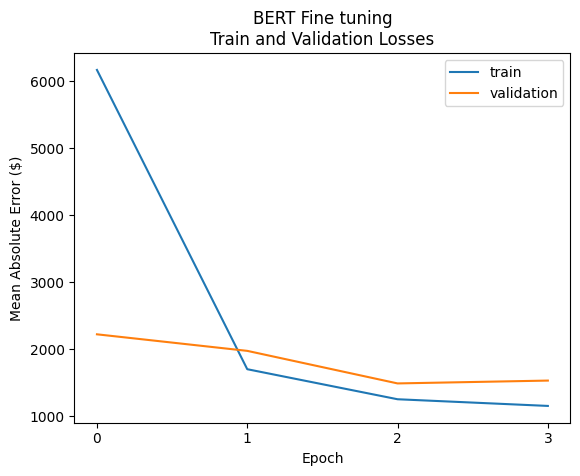

In [25]:
# plot train and val losses
import matplotlib.pyplot as plt
plt.plot(train_losses, label='train')
plt.plot(test_losses, label='validation')
plt.title('BERT Fine tuning\nTrain and Validation Losses')
# integer x ticks
plt.xticks(range(len(train_losses)))
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error ($)')
plt.legend()
plt.show()
